In [2]:
!pip install opencv-python opencv-contrib-python

In [6]:
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

In [7]:
train_path = 'Bag-of-Visual-Words/dataset/train'
test_path = 'Bag-of-Visual-Words/dataset/test'
no_clusters = 100
kernel_type = 'linear'

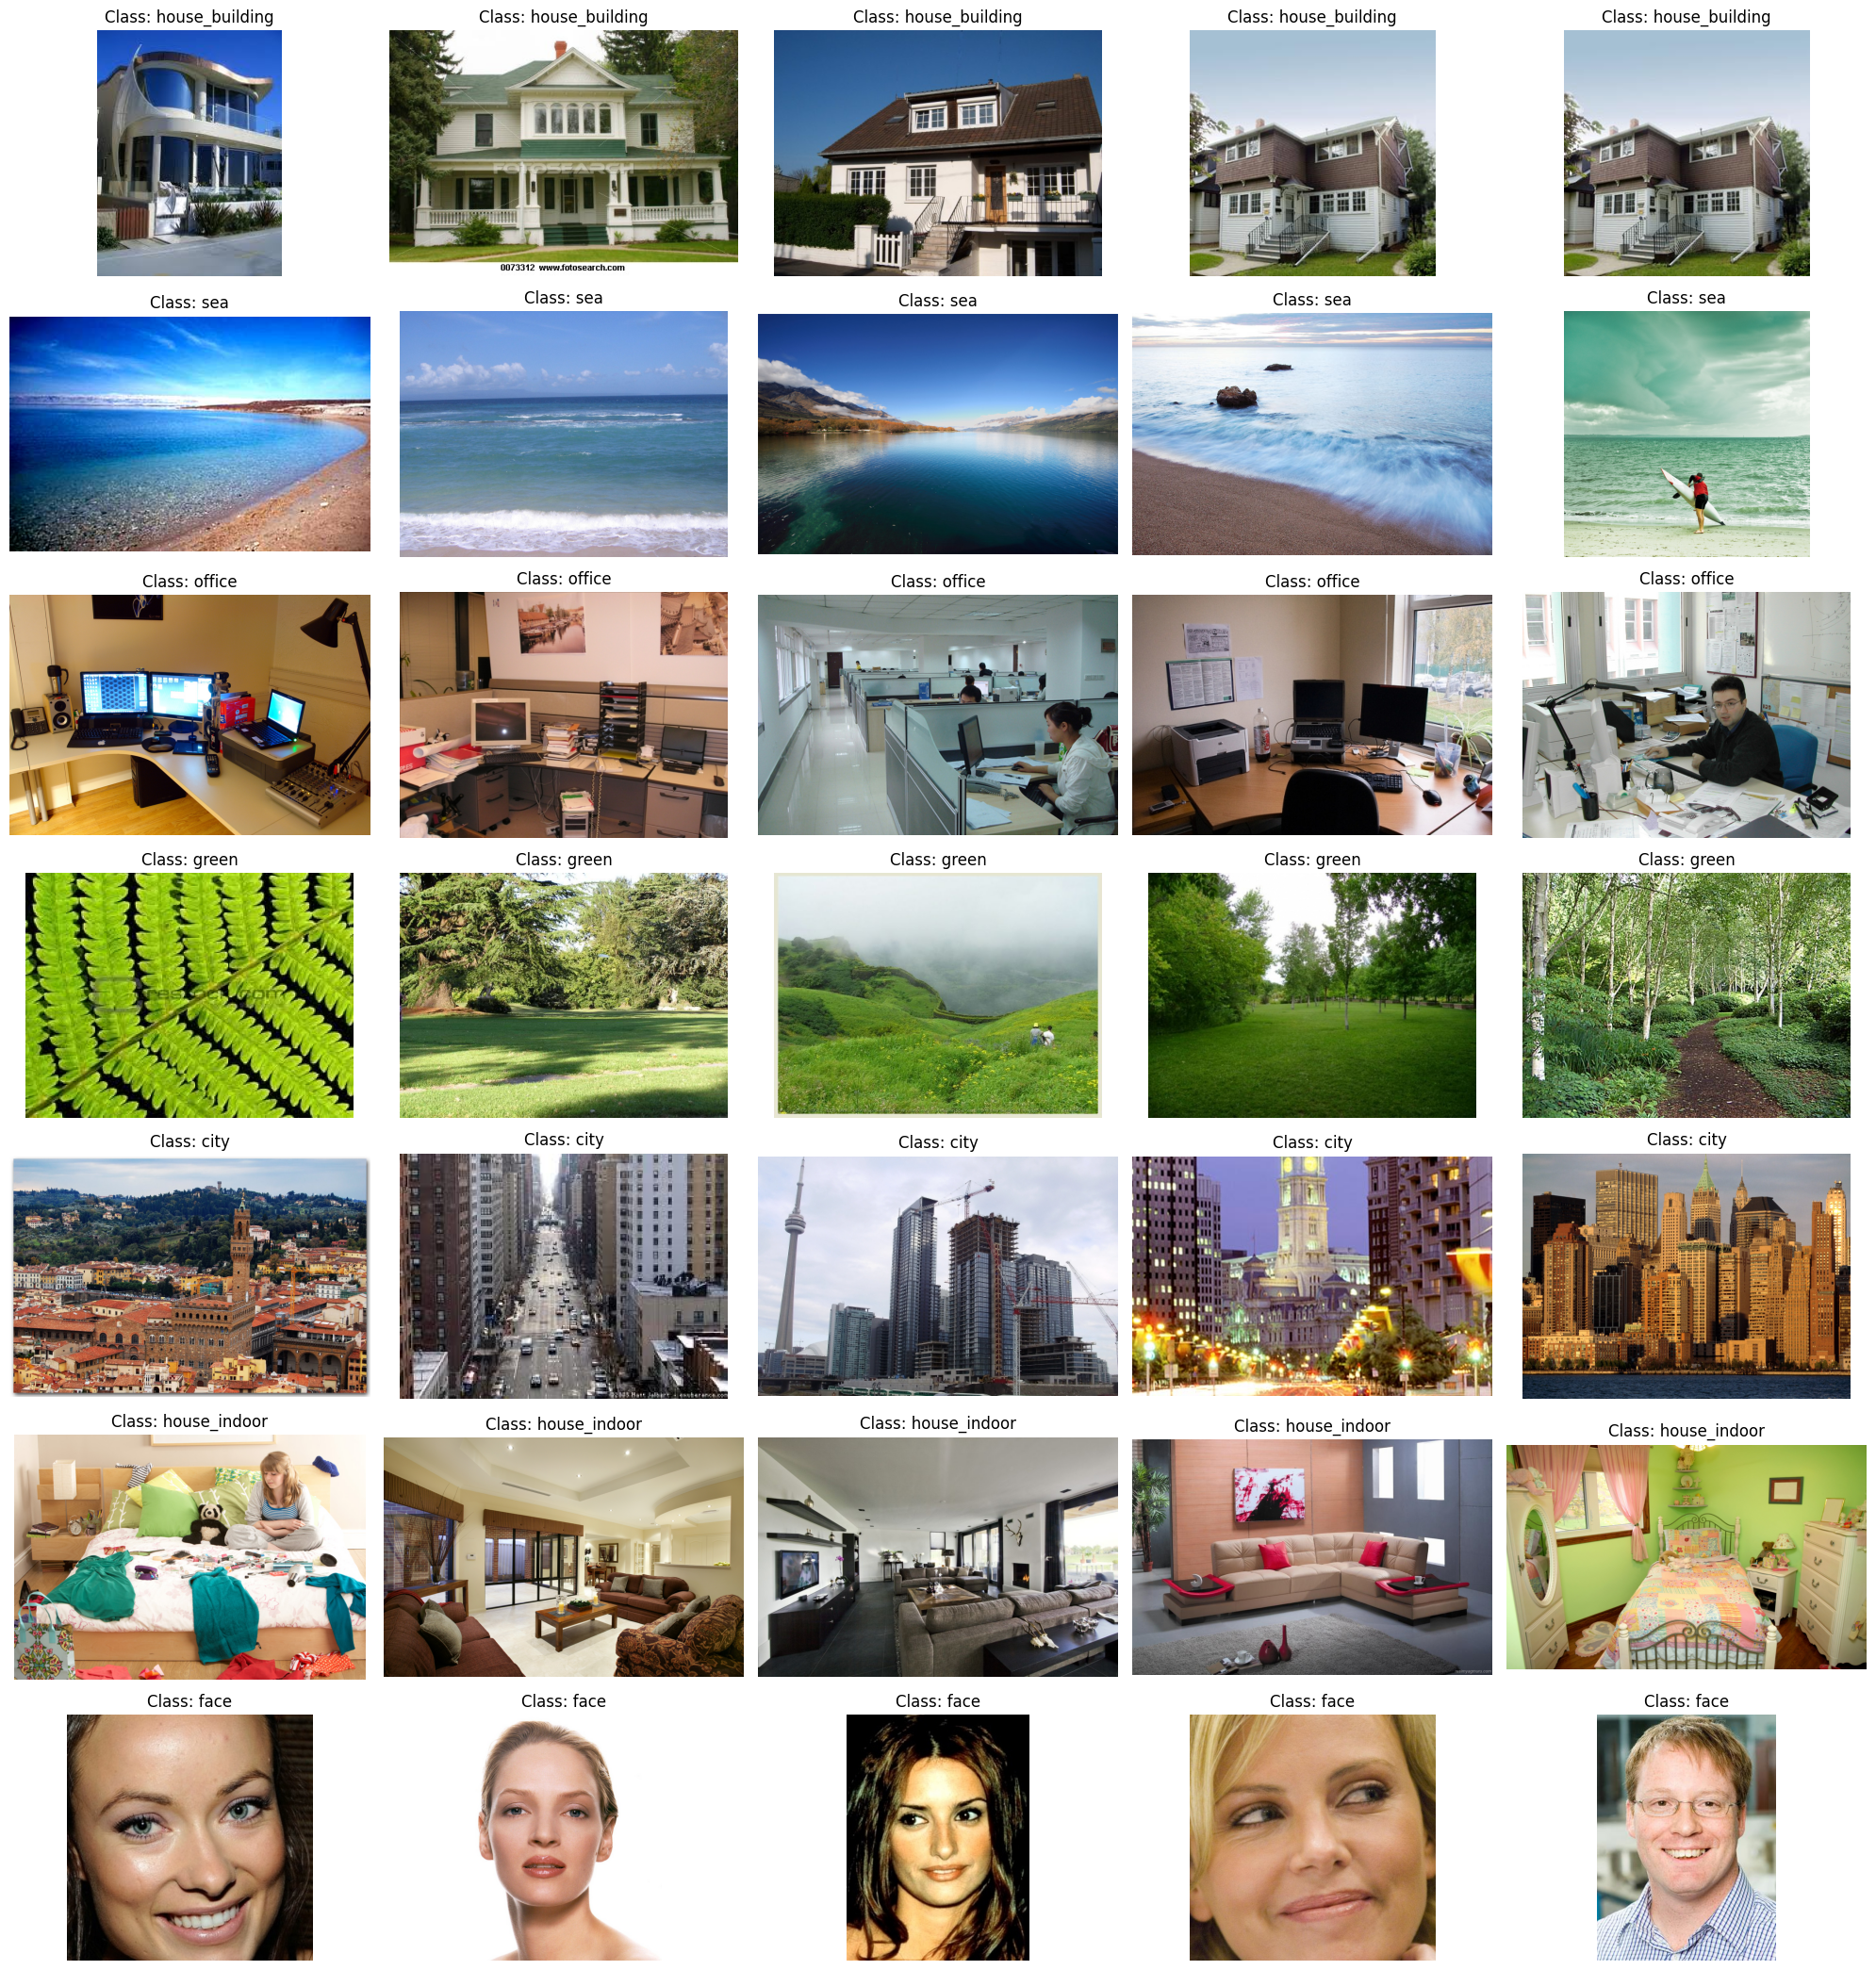

In [18]:
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join

def display_sample_images(path, num_samples=3):
    classes = os.listdir(path)
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(num_samples * 4, len(classes) * 3))

    for i, cls in enumerate(classes):
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for j in range(num_samples):
            img_path = join(path, cls, images[j])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if len(classes) == 1:
                ax = axs[j]
            else:
                ax = axs[i, j]
            ax.imshow(img)
            ax.set_title(f"Class: {cls}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images from training dataset
display_sample_images(train_path, num_samples=5)


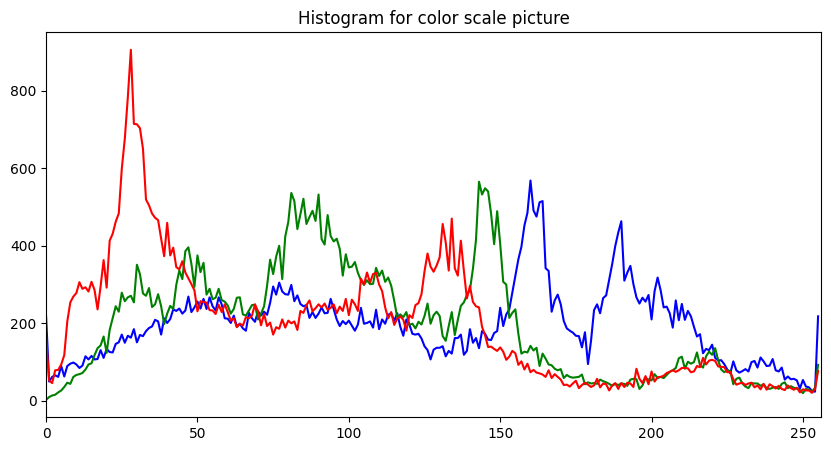

In [19]:
def plot_image_histogram(image_path):
    img = cv2.imread(image_path)
    color = ('b', 'g', 'r')
    plt.figure(figsize=(10, 5))
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(histr, color=col)
        plt.xlim([0, 256])
    plt.title('Histogram for color scale picture')
    plt.show()

# Plot histogram for an example image
example_image_path = join(train_path, os.listdir(train_path)[0], os.listdir(join(train_path, os.listdir(train_path)[0]))[0])
plot_image_histogram(example_image_path)


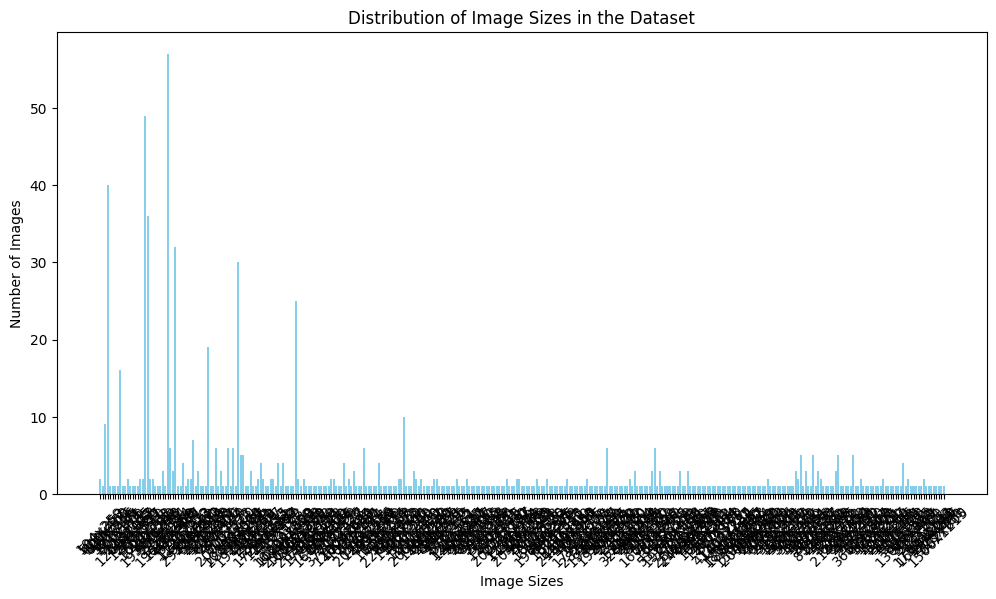

In [20]:
def plot_image_sizes(path):
    sizes = {}
    classes = os.listdir(path)
    for cls in classes:
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for image in images:
            img = cv2.imread(join(path, cls, image))
            size = f"{img.shape[1]}x{img.shape[0]}"
            if size in sizes:
                sizes[size] += 1
            else:
                sizes[size] = 1

    plt.figure(figsize=(12, 6))
    plt.bar(sizes.keys(), sizes.values(), color='skyblue')
    plt.xlabel('Image Sizes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Image Sizes in the Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Plot image sizes distribution
plot_image_sizes(train_path)


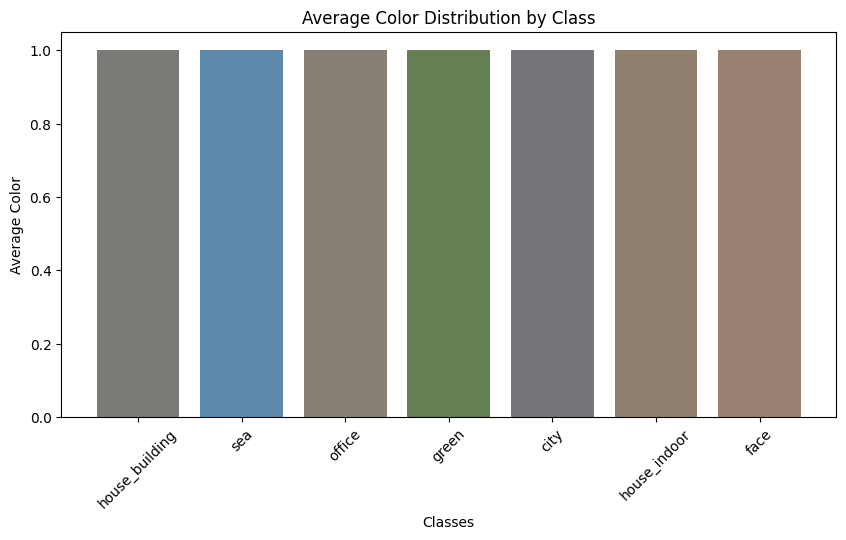

In [25]:
def plot_average_color_distribution(path):
    classes = os.listdir(path)
    avg_color_per_class = {cls: np.zeros(3, dtype=np.float64) for cls in classes}
    count_per_class = {cls: 0 for cls in classes}

    for cls in classes:
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for img_file in images:
            img = cv2.imread(join(path, cls, img_file))
            avg_color = img.mean(axis=0).mean(axis=0)
            avg_color_per_class[cls] += avg_color
            count_per_class[cls] += 1

    for cls in classes:
        avg_color_per_class[cls] /= count_per_class[cls]

    # Plotting
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(classes)), [1]*len(classes), color=[(avg_color_per_class[cls][2]/255, avg_color_per_class[cls][1]/255, avg_color_per_class[cls][0]/255) for cls in classes])
    plt.xlabel('Classes')
    plt.ylabel('Average Color')
    plt.title('Average Color Distribution by Class')
    plt.xticks(range(len(classes)), classes, rotation=45)
    plt.show()

# Call the function with the correct path
plot_average_color_distribution(train_path)



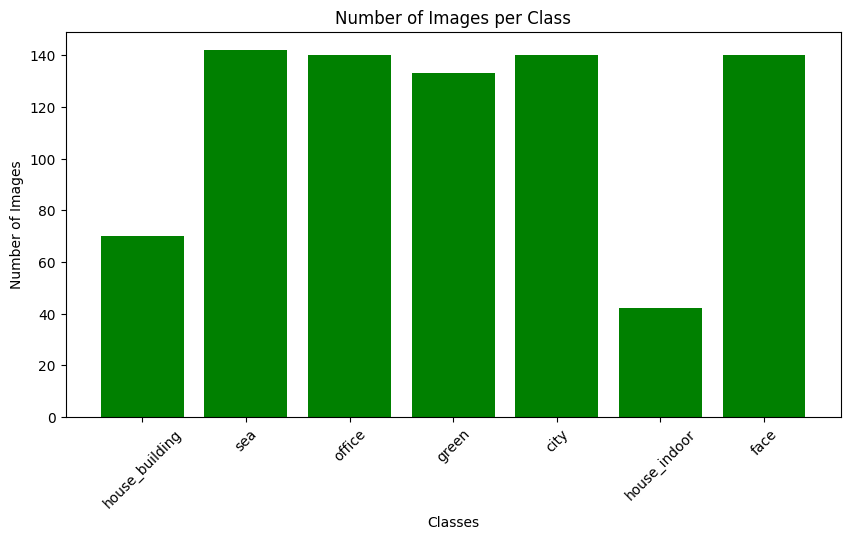

In [22]:
def plot_class_distribution(path):
    class_counts = {}
    classes = os.listdir(path)
    for cls in classes:
        class_counts[cls] = len([name for name in listdir(join(path, cls)) if isfile(join(path, cls, name))])

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='green')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.xticks(rotation=45)
    plt.show()

# Call the function
plot_class_distribution(train_path)


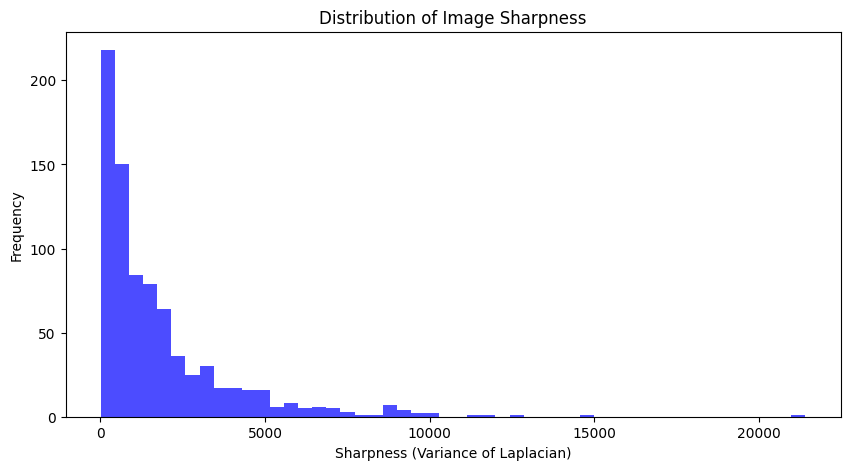

In [23]:
def plot_image_sharpness_distribution(path):
    sharpness_values = []
    classes = os.listdir(path)
    for cls in classes:
        images = [f for f in listdir(join(path, cls)) if isfile(join(path, cls, f))]
        for image in images:
            img = cv2.imread(join(path, cls, image), 0)
            laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
            sharpness_values.append(laplacian_var)

    plt.figure(figsize=(10, 5))
    plt.hist(sharpness_values, bins=50, color='blue', alpha=0.7)
    plt.xlabel('Sharpness (Variance of Laplacian)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Sharpness')
    plt.show()

# Call the function
plot_image_sharpness_distribution(train_path)


In [8]:
def getFiles(train, path):
    images = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            images.append(os.path.join(folder_path, file))
    if train:
        np.random.shuffle(images)
    return images

# Function to read images
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img, (150, 150))



In [9]:
# Function to get descriptors
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

# Function to stack all descriptors vertically in a numpy array
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    return descriptors

# Function to cluster descriptors
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters=no_clusters).fit(descriptors)
    return kmeans


In [10]:
def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

In [11]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features


def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)

    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)

    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")



In [12]:
# Function to extract features
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j].reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

# Function to normalize features
def normalizeFeatures(scale, features):
    return scale.transform(features)

# Function to plot histogram of features
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:, h], dtype=np.int32)) for h in range(no_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

# Function to select the best SVM parameters
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

# Function to train the SVM classifier
def findSVM(im_features, train_labels, kernel):
    features = im_features
    if kernel == "precomputed":
        features = np.dot(im_features, im_features.T)
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param = params['C']
    gamma_param = params['gamma']
    class_weight = {i: 807 / (7 * count) for i, count in enumerate(np.bincount(train_labels.astype(int)))}
    svm = SVC(kernel=kernel, C=C_param, gamma=gamma_param, class_weight=class_weight)
    svm.fit(features, train_labels)
    return svm

# Function to plot confusion matrix
def plotConfusionMatrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        title = 'Normalized confusion matrix' if normalize else 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
           title=title, ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                    ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


Train images path detected.
Descriptors vstacked.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Descriptors clustered.
Images features extracted.
Train images normalized.


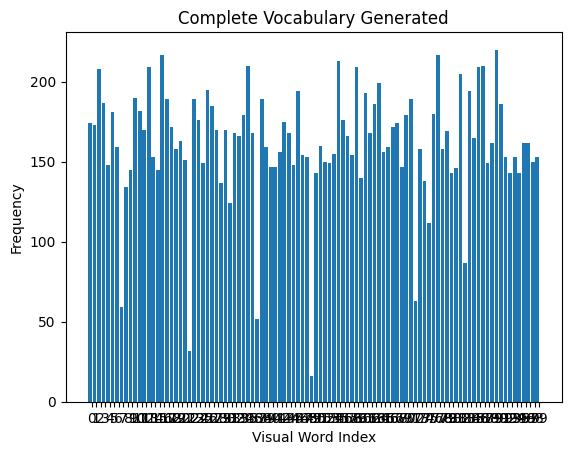

Features histogram plotted.
SVM fitted.
Training completed.
Test images path detected.
Test images classified.


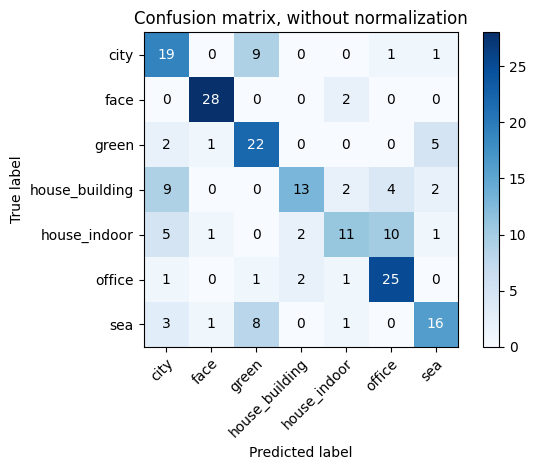

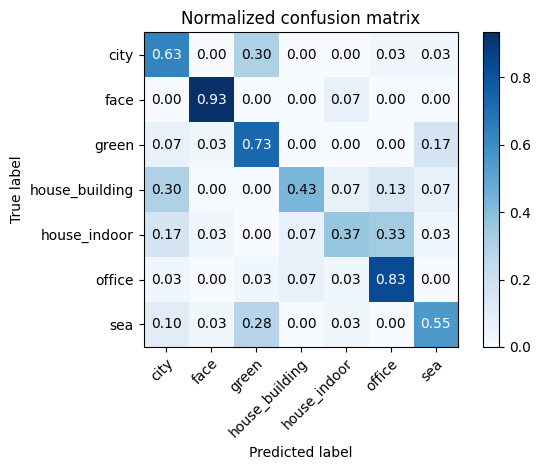

Confusion matrixes plotted.
accuracy score: 0.641
Accuracy calculated.
Execution done.


In [13]:
# Main function to train and test the model
def execute(train_path, test_path, no_clusters, kernel):
    kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
    testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)

# Execute the program
execute(train_path, test_path, no_clusters, kernel_type)

Train images path detected.
Descriptors vstacked.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Descriptors clustered.
Images features extracted.
Train images normalized.


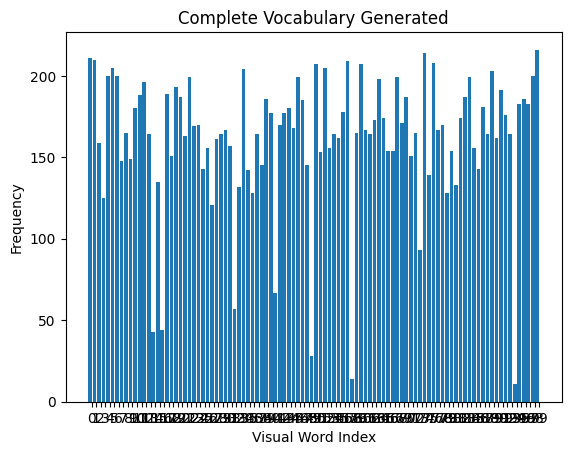

Features histogram plotted.
SVM fitted.
Training completed.
Test images path detected.
Test images classified.


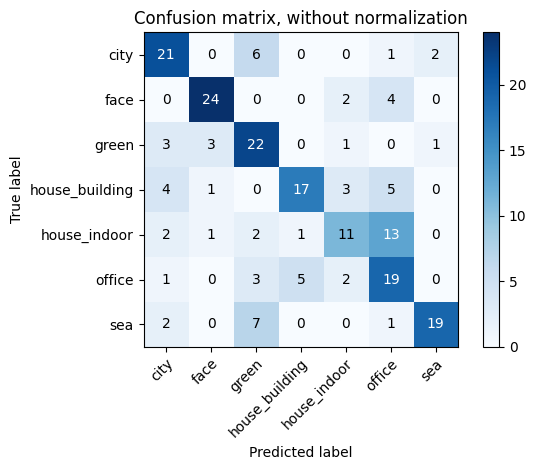

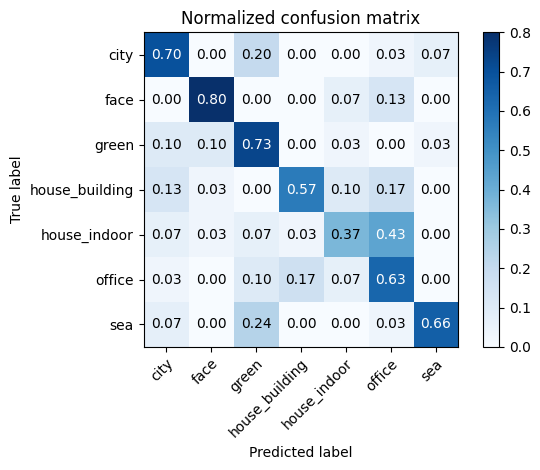

Confusion matrixes plotted.
accuracy score: 0.636
Accuracy calculated.
Execution done.


In [15]:
kernel_type='precomputed'

execute(train_path, test_path, no_clusters, kernel_type)

Train images path detected.
Descriptors vstacked.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Descriptors clustered.
Images features extracted.
Train images normalized.


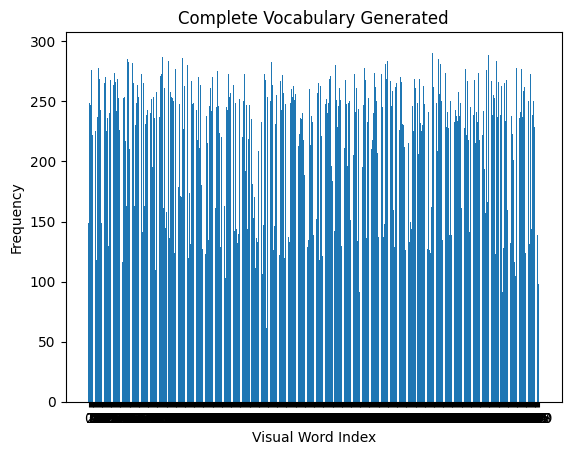

Features histogram plotted.
SVM fitted.
Training completed.
Test images path detected.
Test images classified.


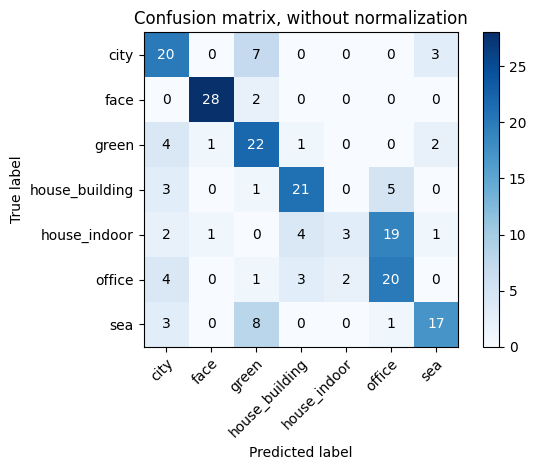

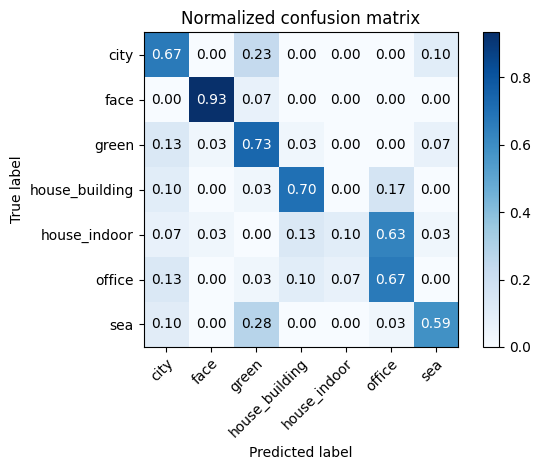

Confusion matrixes plotted.
accuracy score: 0.627
Accuracy calculated.
Execution done.


In [16]:
kernel_type='linear'
no_clusters=500

execute(train_path, test_path, no_clusters, kernel_type)

Train images path detected.
Descriptors vstacked.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Descriptors clustered.
Images features extracted.
Train images normalized.


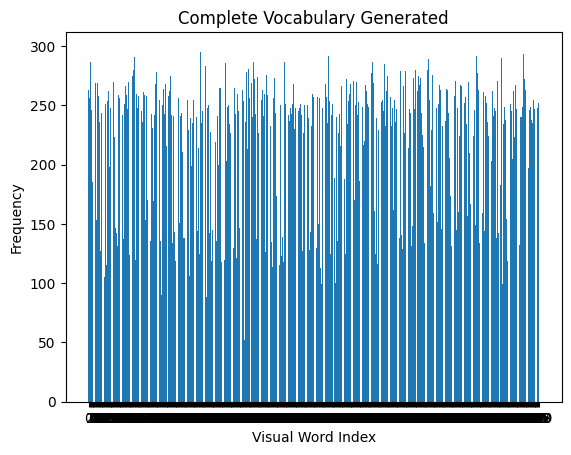

Features histogram plotted.
SVM fitted.
Training completed.
Test images path detected.
Test images classified.


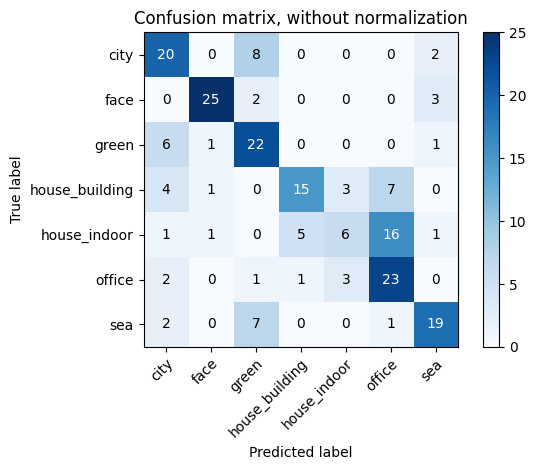

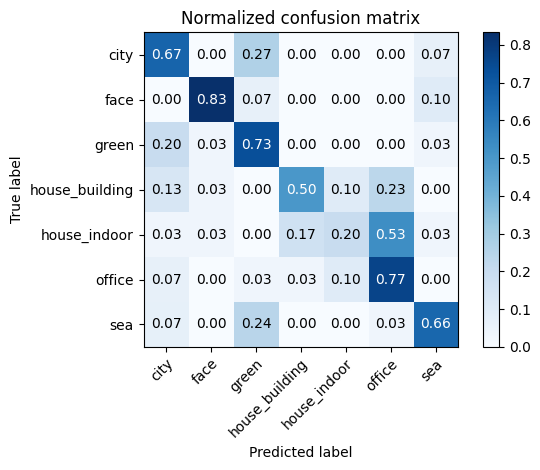

Confusion matrixes plotted.
accuracy score: 0.622
Accuracy calculated.
Execution done.


In [17]:
kernel_type='precomputed'
no_clusters=500

execute(train_path, test_path, no_clusters, kernel_type)